In [1]:
from zeno_client import ZenoClient, ZenoMetric
import pandas as pd
import json
import os
from dotenv import load_dotenv
import numpy as np
import matplotlib.pyplot as plt


load_dotenv(override=True)

False

In [2]:
import sys
sys.path.append('/home/jhsia2/ragged')
from file_utils import load_json

In [3]:
def get_precision(guess_wiki_id_set, gold_wiki_id_set):
    precision = np.mean([[s in gold_wiki_id_set] for s in guess_wiki_id_set])
    return precision
def get_recall(guess_wiki_id_set, gold_wiki_id_set):
    # print(guess_wiki_id_set)
    # print(gold_wiki_id_set)
    recall = np.mean([[s in guess_wiki_id_set] for s in gold_wiki_id_set]) if len(gold_wiki_id_set) > 0 else 0.0
    return recall

In [4]:
root_dir = '/data/tir/projects/tir6/general/afreens/dbqa'
results_dir = os.path.join(root_dir, 'reader_results')
# client = ZenoClient('zen_EZ7LuqItWgObcQmIvNZVytvhtTh8JMs2HrSzzfXsiIg')
# print('hi')

dataset = 'nq'
if 'bioasq' in dataset:
    docid_key = 'pmid'
    docid_name = 'pm'
    section_key = 'section'
    section_name = 'sec'
else:
    docid_key = 'wikipedia_id'
    docid_name = 'wiki'
    section_key = 'start_paragraph_id'
    section_name = 'par'

id2title = load_json(os.path.join(root_dir, f'data/corpus_files/{docid_name}_{section_name}_id2title.json'))

gold_data = load_json(os.path.join(root_dir, 'data/gold_zeno_files', f"gold_{dataset.split('complete_')[-1]}_zeno_file.json"), sort_by_id = True)

questions_categorized = load_json(os.path.join(root_dir, f'data/questions_categorized/{dataset}_questions_categorized.json'))

reading from /data/tir/projects/tir6/general/afreens/dbqa/data/corpus_files/wiki_par_id2title.json
reading from /data/tir/projects/tir6/general/afreens/dbqa/data/gold_zeno_files/gold_nq_zeno_file.json
reading from /data/tir/projects/tir6/general/afreens/dbqa/data/questions_categorized/nq_questions_categorized.json


In [5]:

def combine_gold_and_compiled(output_data, gold_data, questions_categorized, is_bioasq = False):
    if is_bioasq:
        docid_key = 'pmid'
        docid_name = 'pm'
        section_key = 'section'
        section_name = 'sec'
    else:
        docid_key = 'wikipedia_id'
        docid_name = 'wiki'
        section_key = 'start_paragraph_id'
        section_name = 'par'
    
    for i, (od, gd) in enumerate(zip(output_data, gold_data)):
        if(od['id'] != gd['id']):
            print(od, gd)
            break
        # od['dataset'] = gd['dataset']
        od['question_category'] = questions_categorized[od['id']]
        od['gold_answer_set'] = gd['output']['answer_set']
        od[f'gold_{docid_name}_id_set'] = gd['output'][f'{docid_name}_id_set']
        od[f'gold_{docid_name}_{section_name}_id_set'] = gd['output'][f'{docid_name}_{section_name}_id_set']
        od['gold_title_set'] = gd['output']['title_set']
    return output_data

In [14]:
def get_reader_df(top_k, combined_data, is_bioasq = False):
    if is_bioasq:
        docid_key = 'pmid'
        docid_name = 'pm'
        section_key = 'section'
        section_name = 'sec'
    else:
        docid_key = 'wikipedia_id'
        docid_name = 'wiki'
        section_key = 'start_paragraph_id'
        section_name = 'par'
    return pd.DataFrame(
        {
            "question": [d['input'] for d in combined_data],
            # "dataset": [d['dataset'] for d in combined_data],
            "question_category": [d['question_category'] for d in combined_data],
            "id": [d['id'] for d in combined_data],
            "output": [
                # json.dumps(
                    {   
                        "gold answer set": ', '.join(d['gold_answer_set']),
                        # "gold title set": ', '.join(d['gold_title_set']),
                        # "gold context set": '\n'.join(d['gold_text_set']),
                        # "gold context": d['gold_context'],
                        "answer": d["output"]["answer"],
                        # "retrieved context": [
                        #     {
                        #         # "{docid_name}_id": None,
                        #         # "text": None,
                        #         # "score": None,
                        #         # "{docid_name}_id_match": None,
                        #         # "{docid_name}_{section_name}_id_match": None
                        #     }
                        # ] if top_k == 'baseline' else [
                        #     {
                        #         f"{docid_name}_id": "[{idx}]({url})".format(
                        #             idx=id2title.get(r[f"{docid_name}_id"], 'Title not available.'),
                        #             url="https://pubmed.ncbi.nlm.nih.gov/"
                        #             + r[f"{docid_name}_id"],
                        #         ),
                        #         "text": r["text"],
                        #         # "score": r.get('score', None),
                        #         f"{docid_name}_id_match": r[f"{docid_name}_id_match"],
                        #         f"{docid_name}_{section_name}_id_match": r[f"{docid_name}_{section_name}_id_match"],
                        #         "answer_in_context": r["answer_in_context"]
                        #     }
                        #     if len(r['text'])!=0 else {}
                        # for r in d["output"]["retrieved"]
                        # ],
                    }
                # )
                for d in combined_data
            ],
            
            f"gold {docid_name}_{section_name}_id set size": [
                len(d[f"gold_{docid_name}_{section_name}_id_set"]) for d in combined_data
            ],
            # "max_score": [0 for d in combined_data] if top_k == 'baseline' else [
            #     d["output"]["retrieved"][0]["score"] for d in combined_data
            # ],
            # "avg_score": [0 for d in combined_data] if top_k == 'baseline' else [
            #     np.mean([r["score"] for r in d["output"]["retrieved"]]) for d in combined_data
            # ],
            "f1": [
                d["output"]["answer_evaluation"]["f1"] for d in combined_data
            ],
            # "bertscore_precision": [
            #     d["output"]["answer_evaluation"]["bertscore"]["bertscore_precision"] for d in combined_data
            # ],
            # "bertscore_recall": [
            #     d["output"]["answer_evaluation"]["bertscore"]["bertscore_recall"] for d in combined_data
            # ],
            # "bertscore_f1": [
            #     d["output"]["answer_evaluation"]["bertscore"]["bertscore_f1"] for d in combined_data
            # ],
            "exact_match": [
                d["output"]["answer_evaluation"]["exact_match"] for d in combined_data
            ],
            "substring_match": [
                d["output"]["answer_evaluation"]["substring_match"] for d in combined_data
            ],
            "answer_in_context": [
                d["output"]["summary context evaluation"]["answer_in_context"] for d in combined_data
            ],
            f"any {docid_name}_id_match": [False for d in combined_data] if top_k == 'baseline' else [
                d["output"]["summary context evaluation"][f"{docid_name}_id_match"] for d in combined_data
            ],
            f"any {docid_name}_{section_name}_id_match": [False for d in combined_data] if top_k == 'baseline' else [
                d["output"]["summary context evaluation"][f"{docid_name}_{section_name}_id_match"] for d in combined_data
            ],
            f"precision {docid_name}_id_match": [0 for d in combined_data] if top_k == 'baseline' else [
                get_precision(set([r.get(f"{docid_name}_id", None) for r in d["output"]["retrieved"]]), d[f'gold_{docid_name}_id_set']) for d in combined_data
            ],
            f"precision {docid_name}_{section_name}_id_match": [0 for d in combined_data] if top_k == 'baseline' else [
                get_precision(set([r.get(f"{docid_name}_{section_name}_id", None) for r in d["output"]["retrieved"]]), d[f'gold_{docid_name}_{section_name}_id_set']) for d in combined_data
            ],
            f"recall {docid_name}_id_match": [0 for d in combined_data] if top_k == 'baseline' else [
                get_recall(set([r.get(f"{docid_name}_id", None) for r in d["output"]["retrieved"]]), d[f'gold_{docid_name}_id_set']) for d in combined_data
            ],
            f"recall {docid_name}_{section_name}_id_match": [0 for d in combined_data] if top_k == 'baseline' else [
                get_recall(set([r.get(f"{docid_name}_{section_name}_id", None) for r in d["output"]["retrieved"]]), d[f'gold_{docid_name}_{section_name}_id_set']) for d in combined_data
            ],
        }
    )

In [15]:
reader_models = ['flanUl2', 'llama_70b', 'flanT5', 'llama_7b', 'llama_70b_2000_truncation', 'llama_7b_2000_truncation']
# reader_models = ['llama_7b_2000_truncation']
# retriever_models = ['gold','colbert', 'bm25']
retriever_models = ['colbert','gold']
# retriever_models = ['gold']
top_ks= ["baseline", "top1", "top2", "top3", "top5", "top10", "top20", "top30", "top50"]
# top_ks =["baseline"]
print(retriever_models)
print(reader_models)
print(top_ks)
output_dfs = {}
for retriever_model in retriever_models:
    for reader_model in reader_models:
        if output_dfs.get(reader_model, None) == None:
            output_dfs[reader_model] = {}
            
    
        print('retriever', retriever_model)
        print('reader', reader_model)
        if retriever_model == 'gold':

            data = load_json(os.path.join(results_dir, reader_model, 'bioasq' if 'bioasq' in dataset else dataset, 'gold', "reader_results_zeno.json"))
                    
            combined_data = combine_gold_and_compiled(data, gold_data, questions_categorized,'bioasq' in dataset)
            output_df = get_reader_df('gold', combined_data, 'bioasq' in dataset)
            output_dfs[reader_model]['gold'] = output_df
        else:
            for top_k in top_ks:
                print(top_k)
                data = load_json(os.path.join(results_dir, reader_model, dataset, retriever_model, f"{top_k}/reader_results_zeno.json"))
                        
                combined_data = combine_gold_and_compiled(data, gold_data, questions_categorized,'bioasq' in dataset)
                output_df = get_reader_df(top_k, combined_data, 'bioasq' in dataset)
                if output_dfs[reader_model].get(retriever_model, None) == None:
                    output_dfs[reader_model][retriever_model] = {}
                if top_k == 'baseline':
                    output_dfs[reader_model]['no_context'] = output_df
                else:
                    output_dfs[reader_model][retriever_model][top_k] = output_df

['colbert', 'gold']
['flanUl2', 'llama_70b', 'flanT5', 'llama_7b', 'llama_70b_2000_truncation', 'llama_7b_2000_truncation']
['baseline', 'top1', 'top2', 'top3', 'top5', 'top10', 'top20', 'top30', 'top50']
retriever colbert
reader flanUl2
baseline
reading from /data/tir/projects/tir6/general/afreens/dbqa/reader_results/flanUl2/nq/colbert/baseline/reader_results_zeno.json
top1
reading from /data/tir/projects/tir6/general/afreens/dbqa/reader_results/flanUl2/nq/colbert/top1/reader_results_zeno.json
top2
reading from /data/tir/projects/tir6/general/afreens/dbqa/reader_results/flanUl2/nq/colbert/top2/reader_results_zeno.json


top3
reading from /data/tir/projects/tir6/general/afreens/dbqa/reader_results/flanUl2/nq/colbert/top3/reader_results_zeno.json
top5
reading from /data/tir/projects/tir6/general/afreens/dbqa/reader_results/flanUl2/nq/colbert/top5/reader_results_zeno.json
top10
reading from /data/tir/projects/tir6/general/afreens/dbqa/reader_results/flanUl2/nq/colbert/top10/reader_results_zeno.json
top20
reading from /data/tir/projects/tir6/general/afreens/dbqa/reader_results/flanUl2/nq/colbert/top20/reader_results_zeno.json
top30
reading from /data/tir/projects/tir6/general/afreens/dbqa/reader_results/flanUl2/nq/colbert/top30/reader_results_zeno.json
top50
reading from /data/tir/projects/tir6/general/afreens/dbqa/reader_results/flanUl2/nq/colbert/top50/reader_results_zeno.json
retriever colbert
reader llama_70b
baseline
reading from /data/tir/projects/tir6/general/afreens/dbqa/reader_results/llama_70b/nq/colbert/baseline/reader_results_zeno.json
top1
reading from /data/tir/projects/tir6/general/afreens/

In [21]:
from matplotlib.cm import get_cmap

name = "tab10"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list
# plt.prop_cycle(color=colors)

/tmp/ipykernel_3374929/1510399323.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap


In [30]:
output_dfs[reader_model].keys()

dict_keys(['colbert', 'no_context', 'gold'])

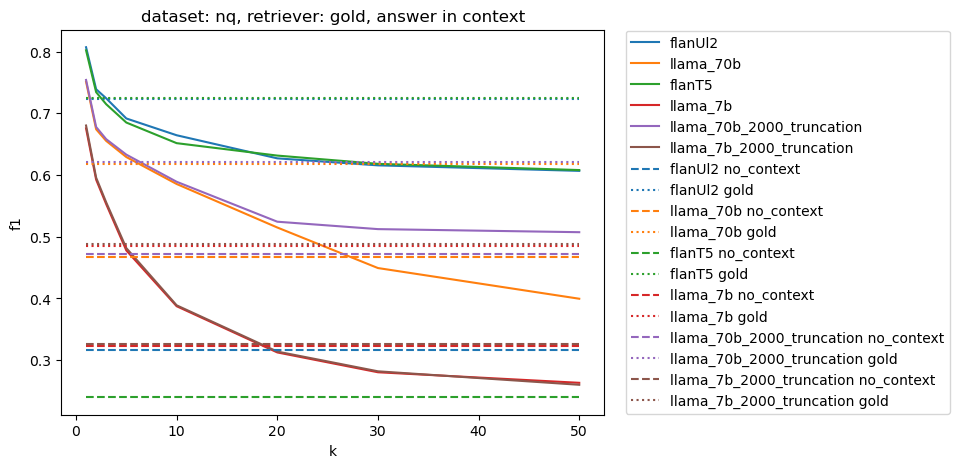

In [38]:
linestyles = ['-', '--', ':']
retriever = 'colbert'
ks = [1, 2, 3, 5, 10 , 20 , 30 , 50]
plt.figure(figsize=(7, 5))
for r, reader_model in enumerate(reader_models):
    reader_perf_by_k = []
    for i, top_k in enumerate(top_ks[1:]):
        k_df =output_dfs[reader_model][retriever][top_k]
        answer_in_context_df = k_df.loc[k_df['answer_in_context'] == True] # CAN CHANGE SLICE CONDITION HERE
        reader_perf_by_k.append(np.mean(answer_in_context_df['f1'].values)) # CAN CHANGE READER METRIC HERE
    plt.plot([1, 2, 3, 5, 10 , 20 , 30 , 50], reader_perf_by_k, label = reader_model, color = colors[r%len(reader_models)], linestyle = linestyles[0])

for r, reader_model in enumerate(reader_models):
    # reader_perf_by = []
    for i, retriever in enumerate(['no_context', 'gold']):
        k_df =output_dfs[reader_model][retriever]
        answer_in_context_df = k_df.loc[k_df['answer_in_context'] == False] # CAN CHANGE SLICE CONDITION HERE
        reader_perf = np.mean(answer_in_context_df['f1'].values) # CAN CHANGE READER METRIC HERE

        plt.hlines(y = reader_perf, xmin = 1, xmax = 50, label = f'{reader_model} {retriever}', color = colors[r%len(reader_models)], linestyle = linestyles[i+1])

plt.title(f'dataset: {dataset}, retriever: {retriever}, answer in context')

plt.xlabel('k')
plt.ylabel('f1')
# plt.ylim(top = 1.0, bottom = 0.0)
# plt.xlim(left = 0, right = 50)
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()

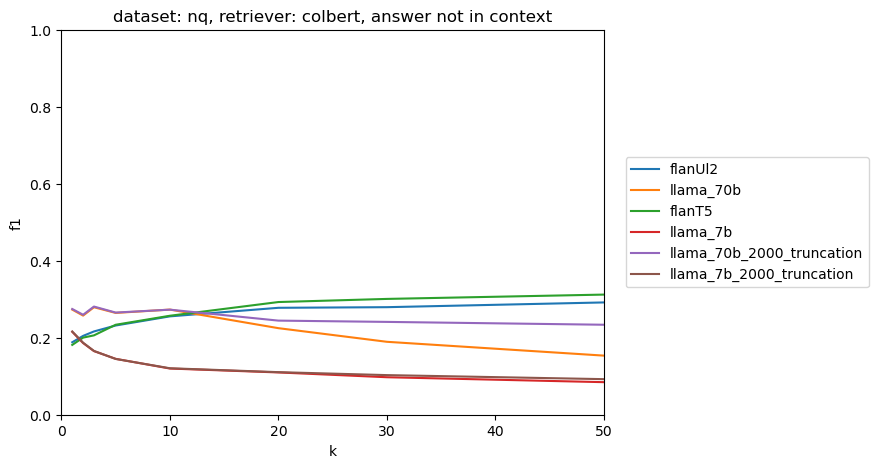

In [28]:
linestyles = ['-', '--', ':']
retriever = 'colbert'
ks = [1, 2, 3, 5, 10 , 20 , 30 , 50]
plt.figure(figsize=(7, 5))
for reader_model in reader_models:
    reader_perf_by_k = []
    for i, top_k in enumerate(top_ks[1:]):
        k_df =output_dfs[reader_model][retriever][top_k]
        answer_in_context_df = k_df.loc[k_df['answer_in_context'] == False] # CAN CHANGE SLICE CONDITION HERE
        reader_perf_by_k.append(np.mean(answer_in_context_df['f1'].values)) # CAN CHANGE READER METRIC HERE
    plt.plot([1, 2, 3, 5, 10 , 20 , 30 , 50], reader_perf_by_k, label = reader_model, linestyle = linestyles[0])
plt.title(f'dataset: {dataset}, retriever: {retriever}, answer not in context')

plt.xlabel('k')
plt.ylabel('f1')
plt.ylim(top = 1.0, bottom = 0.0)
plt.xlim(left = 0, right = 50)
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()

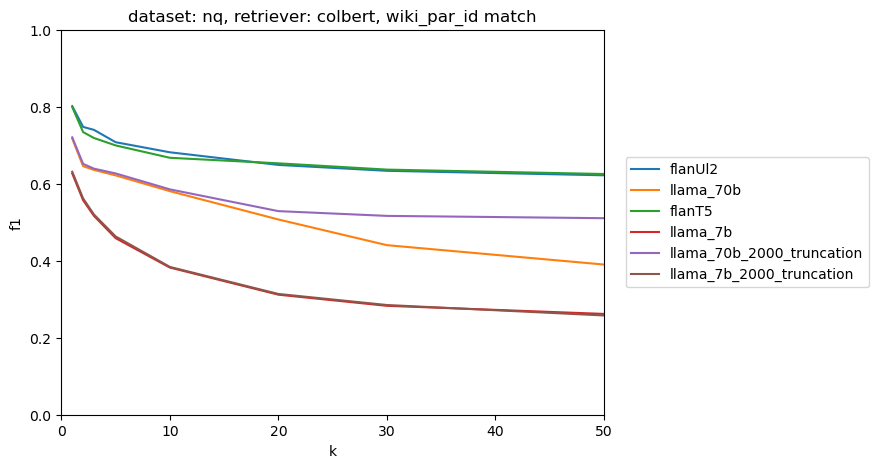

In [16]:
linestyles = ['-', '--', ':']
retriever = 'colbert'
ks = [1, 2, 3, 5, 10 , 20 , 30 , 50]
plt.figure(figsize=(7, 5))
for reader_model in reader_models:
    reader_perf_by_k = []
    for i, top_k in enumerate(top_ks[1:]):
        k_df =output_dfs[reader_model][retriever][top_k]
        answer_in_context_df = k_df.loc[k_df[f'any {docid_name}_{section_name}_id_match'] == True] # CAN CHANGE SLICE CONDITION HERE
        reader_perf_by_k.append(np.mean(answer_in_context_df['f1'].values)) # CAN CHANGE READER METRIC HERE
    plt.plot([1, 2, 3, 5, 10 , 20 , 30 , 50], reader_perf_by_k, label = reader_model, linestyle = linestyles[0])
plt.title(f'dataset: {dataset}, retriever: {retriever}, {docid_name}_{section_name}_id match')

plt.xlabel('k')
plt.ylabel('f1')
plt.ylim(top = 1.0, bottom = 0.0)
plt.xlim(left = 0, right = 50)
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()

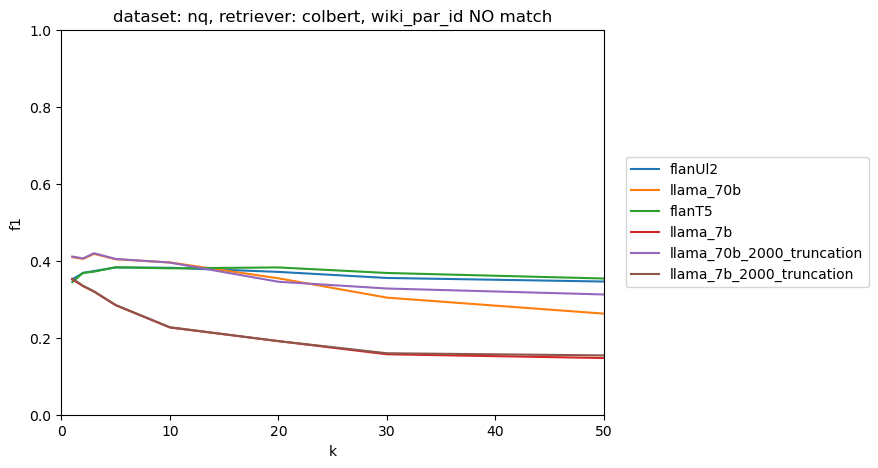

In [17]:
linestyles = ['-', '--', ':']
retriever = 'colbert'
ks = [1, 2, 3, 5, 10 , 20 , 30 , 50]
plt.figure(figsize=(7, 5))
for reader_model in reader_models:
    reader_perf_by_k = []
    for i, top_k in enumerate(top_ks[1:]):
        k_df =output_dfs[reader_model][retriever][top_k]
        answer_in_context_df = k_df.loc[k_df[f'any {docid_name}_{section_name}_id_match'] == False] # CAN CHANGE SLICE CONDITION HERE
        reader_perf_by_k.append(np.mean(answer_in_context_df['f1'].values)) # CAN CHANGE READER METRIC HERE
    plt.plot([1, 2, 3, 5, 10 , 20 , 30 , 50], reader_perf_by_k, label = reader_model, linestyle = linestyles[0])
plt.title(f'dataset: {dataset}, retriever: {retriever}, {docid_name}_{section_name}_id NO match')

plt.xlabel('k')
plt.ylabel('f1')
plt.ylim(top = 1.0, bottom = 0.0)
plt.xlim(left = 0, right = 50)
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()